In [1]:
from datetime import datetime 
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.corpus import stopwords
import nltk

from nltk.tokenize import word_tokenize
from scipy.sparse import csr_matrix
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import pickle
from scipy.sparse import hstack

from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

In [2]:
df = pd.read_csv(r"C:\Users\Chama\OneDrive\Desktop\Tinder\dataset\Data.csv")
df.head()

,user_id,username,age,status,sex,orientation,drinks,drugs,height,job,...,smokes,language,new_languages,body_profile,education_level,dropped_out,bio,interests,other_interests,location_preference
0,fffe3100,Edith Lopez,27,single,f,gay,socially,never,66.0,medicine / health,...,no,"english (fluently), spanish (poorly), sign lan...",interested,athletic,4.0,no,bottom line i love life! i work hard and i lov...,sports,instruments,same state
1,fffe3200,Travis Young,26,single,m,gay,socially,never,68.0,other,...,no,"english (fluently), tagalog (okay), french (po...",interested,fit,3.0,no,"i'm a straightforward, genuine, fun loving (i'...",painting,instruments,anywhere
2,fffe3300,Agnes Smith,20,seeing someone,f,bisexual,socially,sometimes,69.0,other,...,sometimes,"english (fluently), sign language (poorly), fr...",interested,fit,2.0,no,mmmmm yummy tacosss. yoga is where it's at. i ...,instruments,dancing,same city
3,fffe3400,Salvador Klaver,27,single,m,bisexual,socially,sometimes,68.0,computer / hardware / software,...,no,english,not interested,average,3.0,no,i'm a stealth geek. that special mix of techni...,sketching,acting,same city
4,fffe3500,Elana Sewell,22,single,f,bisexual,often,sometimes,68.0,other,...,yes,english,not interested,average,2.0,yes,with the whisper of the wind i was weaved into...,craft,designing,same city


In [3]:
df.shape

(2001, 22)

In [4]:
print("No of NULL values : ", sum(df.isnull().any()))

No of NULL values :  0


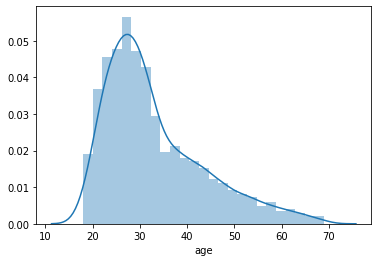

count    2001.000000
mean       33.072464
std        10.483189
min        18.000000
25%        26.000000
50%        30.000000
75%        39.000000
max        69.000000
Name: age, dtype: float64


In [5]:
sns.distplot(df['age'])
plt.show()
print('='*50)
print(df['age'].describe())

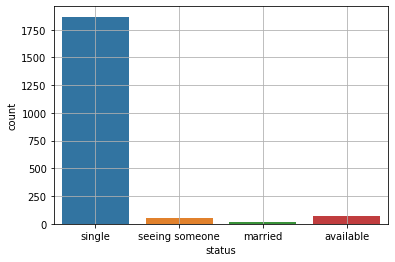

count       2001
unique         4
top       single
freq        1867
Name: status, dtype: object


In [6]:
sns.countplot(df['status'])
plt.grid()
plt.show()

print('='*50)
print(df['status'].describe())

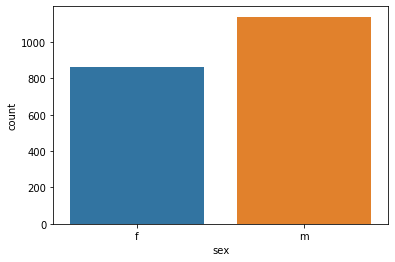

count     2001
unique       2
top          m
freq      1139
Name: sex, dtype: object


In [7]:
sns.countplot(df['sex'])
plt.show()

print('='*50)
print(df['sex'].describe())


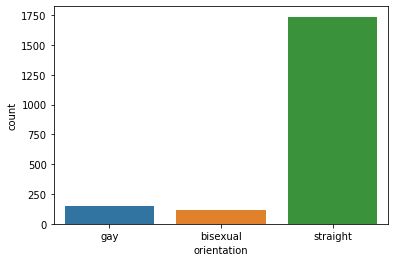

count         2001
unique           3
top       straight
freq          1736
Name: orientation, dtype: object


In [8]:
sns.countplot(df['orientation'])
plt.show()

print('='*50)
print(df['orientation'].describe())

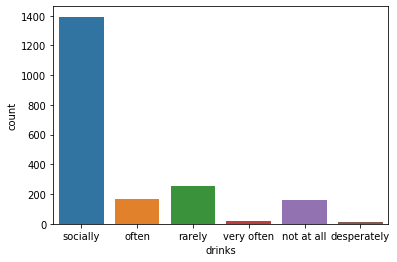

In [9]:
sns.countplot(df['drinks'])
plt.show()

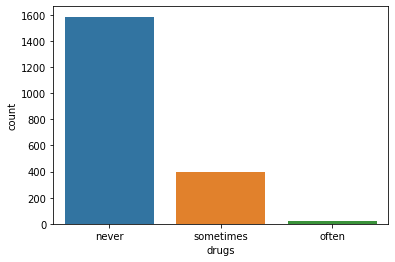

In [10]:
sns.countplot(df['drugs'])
plt.show()

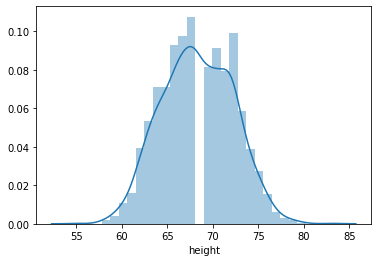

count    2001.000000
mean       68.289855
std         3.895246
min        55.000000
25%        65.000000
50%        68.000000
75%        71.000000
max        83.000000
Name: height, dtype: float64


In [11]:
sns.distplot(df['height'])
plt.show()
print('='*50)
print(df['height'].describe())

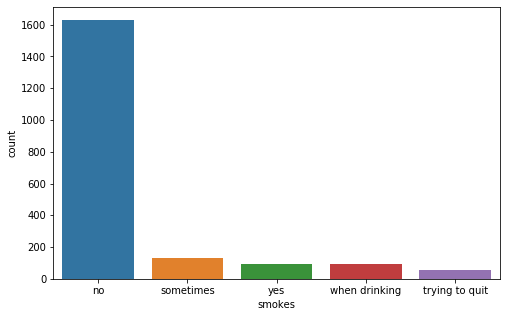

In [12]:
plt.figure(figsize = (8,5))
sns.countplot(df['smokes'])
plt.show()

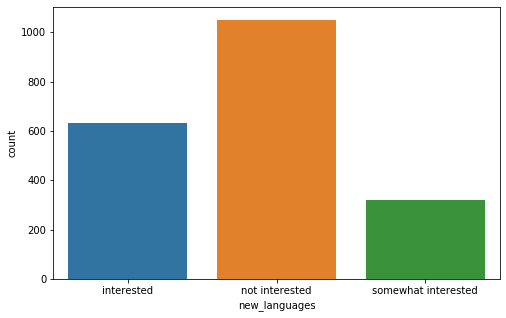

In [13]:
plt.figure(figsize = (8,5))
sns.countplot(df['new_languages'])
plt.show()

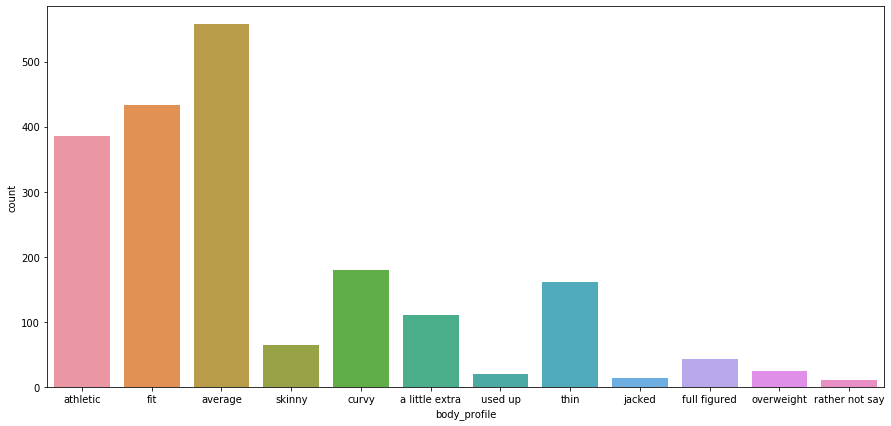

In [14]:
plt.figure(figsize = (15,7))
sns.countplot(df['body_profile'])
plt.show()


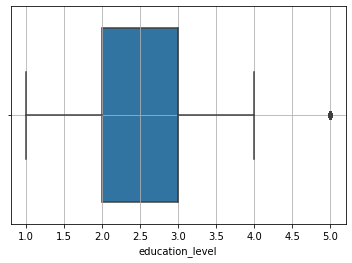

count    2001.000000
mean        2.932534
std         0.812371
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: education_level, dtype: float64


In [15]:
sns.boxplot(x = df['education_level'])
plt.grid()
plt.show()
print('='*50)
print(df['education_level'].describe())

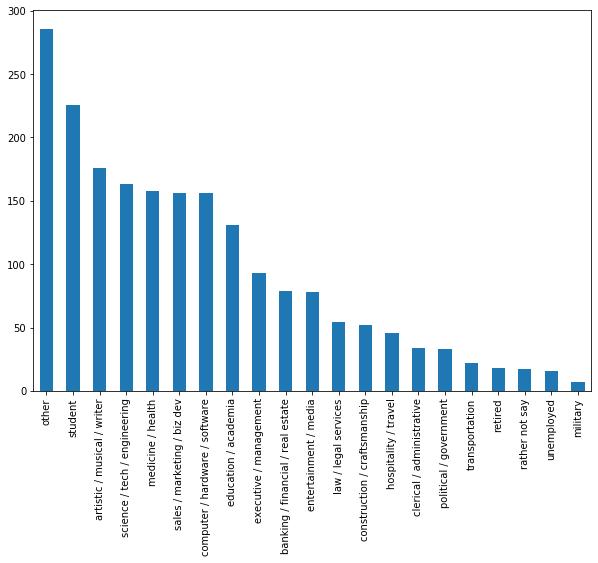

In [16]:
plt.figure(figsize = (10,7))
df['job'].value_counts().plot(kind = 'bar')
plt.show()

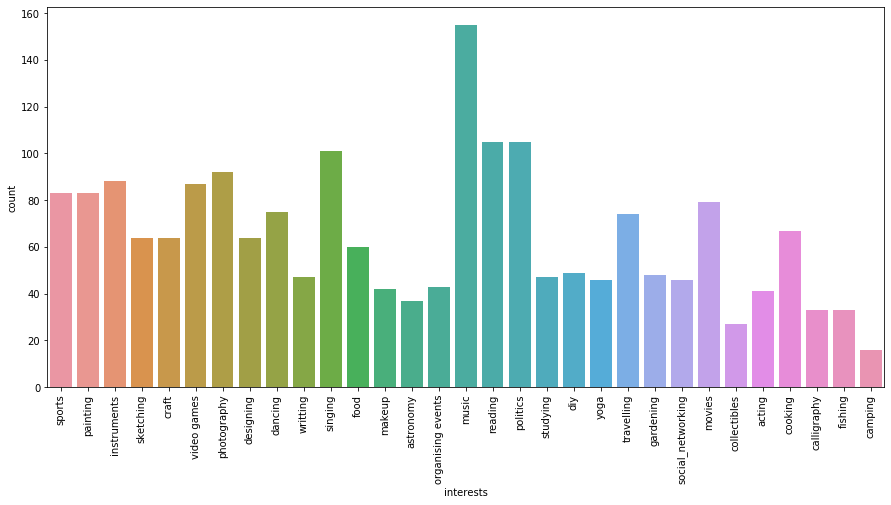

In [17]:
plt.figure(figsize = (15,7))
sns.countplot(df['interests'])
plt.xticks(rotation = 90)
plt.show()

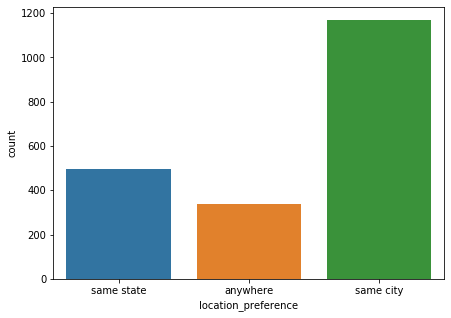

In [18]:
plt.figure(figsize = (7,5))
sns.countplot(df['location_preference'])
plt.show()

In [19]:
user_id = df["user_id"]

df[["CITY","STATE"]] = df.location.str.split(",",expand = True)

df["sex"].replace("f",0,inplace = True)
df["sex"].replace("m",1,inplace = True)

df["orientation"].replace("gay",0,inplace = True)
df["orientation"].replace("bisexual",1,inplace = True)
df["orientation"].replace("straight",2,inplace = True)

df["location_preference"].replace("same city",0,inplace = True)
df["location_preference"].replace("same state",1,inplace = True)
df["location_preference"].replace("anywhere",2,inplace = True)

df["drugs"].replace("never",0,inplace = True)
df["drugs"].replace("sometimes",1,inplace = True)
df["drugs"].replace("often",2,inplace = True)

df.drop(columns=['user_id','username','location'],inplace=True)

In [20]:
df["dogs"] = 0
df["cats"] = 0
for i in range(2001):
    if (df["pets"][i] == "likes dogs and likes cats")or (df["pets"][i] == "likes dogs and dislikes cats") or (df["pets"][i] == "likes dogs") or (df["pets"][i] == "likes dogs and has cats"):
        df["dogs"][i] = 1
    if (df["pets"][i] == "has dogs and has cats")or (df["pets"][i] == "has dogs and dislikes cats") or (df["pets"][i] == "has dogs") or (df["pets"][i] == "has dogs and likes cats"):
        df["dogs"][i] = 0
    if (df["pets"][i] == "dislikes dogs and has cats")or (df["pets"][i] == "dislikes dogs and dislikes cats") or (df["pets"][i] == "dislikes dogs") or (df["pets"][i] == "dislikes dogs and likes cats"):
        df["dogs"][i] = 3
    if (df["pets"][i] == "has cats")or (df["pets"][i] == "dislikes cats") or (df["pets"][i] == "likes cats"):
        df["dogs"][i] = 2
    if (df["pets"][i] == "likes dogs and likes cats")or (df["pets"][i] == "dislikes dogs and likes cats") or (df["pets"][i] == "likes cats") or (df["pets"][i] == "has dogs and likes cats"):
        df["cats"][i] = 1
    if (df["pets"][i] == "has dogs and has cats")or (df["pets"][i] == "dislikes dogs and has cats") or (df["pets"][i] == "has cats") or (df["pets"][i] == "likes dogs and has cats"):
        df["cats"][i] = 0
    if (df["pets"][i] == "has dogs and dislikes cats")or (df["pets"][i] == "dislikes dogs and dislikes cats") or (df["pets"][i] == "dislikes cats") or (df["pets"][i] == "likes dogs and dislikes cats"):
        df["cats"][i] = 3
    if (df["pets"][i] == "has dogs")or (df["pets"][i] == "dislikes dogs") or (df["pets"][i] == "likes dogs"):
        df["cats"][i] = 2

df.drop(columns=['pets'],inplace=True)

In [21]:
def ohe(feature):
    vectorizer = CountVectorizer(binary = True)
    vectorized_feature = vectorizer.fit_transform(feature.values)
    return vectorized_feature

In [22]:
status_vec = ohe(df['status'])

In [23]:
drinks_vec = ohe(df['drinks'])

In [24]:
job_vec = ohe(df['job'])

In [25]:
smokes_vec = ohe(df['smokes'])

In [26]:
new_languages_vec = ohe(df['new_languages'])

In [27]:
body_vec = ohe(df['body_profile'])

In [28]:
dropped_vec = ohe(df['dropped_out'])

In [29]:
loc_vec = ohe(df['CITY'])

In [30]:
df.drop(columns=['job',
                 'body_profile',
                 'dropped_out',
                 'new_languages',
                 'smokes',
                 'drinks',
                 'status'],
        inplace=True)

In [31]:
vecto = np.hstack((drinks_vec.toarray(),
                    body_vec.toarray(),
                    smokes_vec.toarray(),
                    loc_vec.toarray(),
                    new_languages_vec.toarray(),
                    dropped_vec.toarray(),
                    status_vec.toarray(),
                    job_vec.toarray()))

In [32]:
lang = []
for lan in df["language"]:
    l=lan.split(',')
    lang.append(len(l))
df["no_of_lan"] = lang

In [33]:
Xlanguage={}
for i in lan:
    l=[]
    for j in df['language']:
        if i in j.split(' '):
            l.append(1)
        elif i+',' in j.split(' '):
            l.append(1)
        else:
            l.append(0)
    Xlanguage[i]=l

In [34]:
datalan=pd.DataFrame()
for i in Xlanguage:
    datalan[i] = Xlanguage[i]

In [35]:
interests = []
for i in df["interests"]:
    if i not in interests:
        interests.append(i)
for i in df["other_interests"]:
    if i not in interests:
        interests.append(i)
Xinterests={}
for i in interests:
    l=[]
    for j in range(2001):
        if i == df["interests"][j]:
            l.append(1)
        elif i == df["other_interests"][j]:
            l.append(1)
        else:
            l.append(0)
    Xinterests[i]=l
for i in Xinterests:
    datalan[i]=Xinterests[i]


In [36]:
datalan_val = datalan.values
df.drop(columns=['interests',
                 'other_interests',
                 'language'],
        inplace=True)

In [37]:
datascaler=pd.DataFrame()
datascaler = user_id
scaler = StandardScaler()
scaler.fit(df['age'].values.reshape(-1, 1))
datascaler_age=scaler.transform(df['age'].values.reshape(-1, 1))
scaler.fit(df['height'].values.reshape(-1, 1))
datascaler_height=scaler.transform(df['height'].values.reshape(-1, 1))
scaler.fit(df['education_level'].values.reshape(-1, 1))
datascaler_education_level=scaler.transform(df['education_level'].values.reshape(-1, 1))
scaler.fit(df['dogs'].values.reshape(-1, 1))
datascaler_dogs=scaler.transform(df['dogs'].values.reshape(-1, 1))
scaler.fit(df['cats'].values.reshape(-1, 1))
datascaler_cats=scaler.transform(df['cats'].values.reshape(-1, 1))
scaler.fit(df['no_of_lan'].values.reshape(-1, 1))
datascaler_no_of_lan=scaler.transform(df['no_of_lan'].values.reshape(-1, 1))

In [38]:
data_scaler = np.hstack((datascaler_no_of_lan,
                         datascaler_cats,
                         datascaler_dogs,
                         datascaler_education_level,
                         datascaler_age,
                         datascaler_height))

In [39]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [40]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [41]:
def preprocess_text(text_data):
    preprocessed_text = []
    for sentence in tqdm(text_data):
        sent = decontracted(sentence)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = ' '.join(e for e in nltk.word_tokenize(sent) if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [42]:
preprocessed_bio = preprocess_text(df['bio'].values)
df.drop(columns=['bio'],inplace=True)

100%|████████████████████████████████████████████████████████████████████████████| 2001/2001 [00:01<00:00, 1075.30it/s]


In [43]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(preprocessed_bio)]

In [44]:
max_epochs = 100
vec_size = 50
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

In [45]:
d2v= Doc2Vec.load("d2v.model")

In [46]:
bio_vectorized = [d2v.docvecs[str(i)] for i in range(len(preprocessed_bio))]

In [47]:
np.asarray(bio_vectorized).shape

(2001, 50)

In [49]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

s = 0
a = df.dtypes
for i in df:
    if a[s] == "object":
        df[i] = le.fit_transform(df[i])
    s+=1

X = np.hstack((df,dropped_vec.toarray(),status_vec.toarray(),drinks_vec.toarray(),job_vec.toarray(),smokes_vec.toarray(),new_languages_vec.toarray(),body_vec.toarray()))

In [50]:
allin = np.hstack((bio_vectorized,data_scaler,vecto,datalan_val))

In [51]:
from scipy.spatial import distance

def ans_return(a,b):
    return distance.cosine(allin[a],allin[b])

In [52]:
ans = []
Location = 6
City = 7
sex = 1
ori = 2
import random

random.randint(0,9)

def f_gay_def(y):
    s = []
    for i in range(2001):
        if y == i:
            s.append(0)
        elif X[y][Location] == 0 and X[i][City]!=X[y][City]:
            s.append(0)
        elif (X[i][sex] == 0) and (X[i][ori] == 0 or X[i][ori] == 1):
            s.append(ans_return(i,y))
        else :
            s.append(0)
    ans.append(s)

def f_bisexual_def(y):
    s = []
    for i in range(2001):
        if y == i:
            s.append(0)
        elif X[y][Location] == 0 and X[i][City]!=X[y][City]:
            s.append(0)
        elif (X[i][sex]==1)and(X[i][ori]==2):
            s.append(ans_return(i,y))
        elif (X[i][sex]==0)and(X[i][ori]==0 or X[i][ori]==1):
            s.append(ans_return(i,y))
        else :
            s.append(0)
    ans.append(s)
    
def f_straight_def(y):
    s = []
    for i in range(2001):
        if y == i:
            s.append(0)
        elif X[y][Location] == 0 and X[i][City]!=X[y][City]:
            s.append(0)
        elif (X[i][sex] == 1 and (X[i][ori] == 2 or X[i][ori] == 0)):
            s.append(ans_return(i,y))
        else :
            s.append(0)
    ans.append(s)
    
def m_gay_def(y):
    s = []
    for i in range(2001):
        if y == i:
            s.append(0)
        elif X[y][Location] == 0 and X[i][City]!=X[y][City]:
            s.append(0)
        elif (X[i][sex] == 1) and (X[i][ori] == 0 or X[i][ori] == 1):
            s.append(ans_return(i,y))
        else :
            s.append(0)
    ans.append(s)
    
def m_bisexual_def(y):
    s = []
    for i in range(2001):
        if y == i:
            s.append(0)
        elif X[y][Location] == 0 and X[i][City]!=X[y][City]:
            s.append(0)
        elif (X[i][sex]==0)and(X[i][ori]==2):
            s.append(ans_return(i,y))
        elif (X[i][sex]==1)and(X[i][ori]==0 or X[i][ori]==1):
            s.append(ans_return(i,y))
        else :
            s.append(0)
    ans.append(s)

def m_straight_def(y):
    s = []
    for i in range(2001):
        if y == i:
            s.append(0)
        elif X[y][Location] == 0 and X[i][City]!=X[y][City]:
            s.append(0)
        elif (X[i][sex] == 0 and (X[i][ori] == 2 or X[i][ori] == 0)):
            s.append(ans_return(i,y))
        else :
            s.append(0)
    ans.append(s)

In [53]:
for i in range(2001):
    if X[i][1] == 0:
        if X[i][2] == 0:
            f_gay_def(i)
        if X[i][2] == 1:
            f_bisexual_def(i)
        if X[i][2] == 2:
            f_straight_def(i)
    if X[i][1] == 1:
        if X[i][2] == 0:
            m_gay_def(i)
        if X[i][2] == 1:
            m_bisexual_def(i)
        if X[i][2] == 2:
            m_straight_def(i)  
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000


In [54]:
a=[]
for i in range(2001):
    l=[]
    for j in range(2001):
        if ans[j][i] == 0:
            l.append(0)
        elif ans[j][i] < 0:
            l.append(0)
        else :
            l.append((ans[j][i])*100)
    a.append(l)

data=pd.DataFrame()
s=0
for i in user_id:
    data[i]=a[s]
    s+=1

data.head()

,fffe3100,fffe3200,fffe3300,fffe3400,fffe3500,fffe3600,fffe3700,fffe3800,fffe3900,fffe31003000,...,fffe3100390039003200,fffe3100390039003300,fffe3100390039003400,fffe3100390039003500,fffe3100390039003600,fffe3100390039003700,fffe3100390039003800,fffe3100390039003900,fffe3200300030003000,fffe3200300030003100
0,0.000000,0.0,70.658941,0.000000,66.565109,0.000000,58.646809,0.000000,0.00000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,69.272708,0.0,0.0,0.0
1,0.000000,0.0,0.000000,75.860291,0.000000,84.438763,0.000000,0.000000,61.41098,0.0,...,54.779738,0.0,94.409403,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,70.658941,0.0,0.000000,0.000000,69.728644,0.000000,77.141399,77.640779,0.00000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,78.116618,0.000000,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,66.565109,0.0,69.728644,0.000000,0.000000,0.000000,60.937392,67.291224,0.00000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,61.075082,0.000000,0.0,0.0,0.0


In [55]:
data.set_index(user_id,inplace=True)
data.head()

,fffe3100,fffe3200,fffe3300,fffe3400,fffe3500,fffe3600,fffe3700,fffe3800,fffe3900,fffe31003000,...,fffe3100390039003200,fffe3100390039003300,fffe3100390039003400,fffe3100390039003500,fffe3100390039003600,fffe3100390039003700,fffe3100390039003800,fffe3100390039003900,fffe3200300030003000,fffe3200300030003100
user_id,,,,,,,,,,,,,,,,,,,,,
fffe3100,0.000000,0.0,70.658941,0.000000,66.565109,0.000000,58.646809,0.000000,0.00000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,69.272708,0.0,0.0,0.0
fffe3200,0.000000,0.0,0.000000,75.860291,0.000000,84.438763,0.000000,0.000000,61.41098,0.0,...,54.779738,0.0,94.409403,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
fffe3300,70.658941,0.0,0.000000,0.000000,69.728644,0.000000,77.141399,77.640779,0.00000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,78.116618,0.000000,0.0,0.0,0.0
fffe3400,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
fffe3500,66.565109,0.0,69.728644,0.000000,0.000000,0.000000,60.937392,67.291224,0.00000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,61.075082,0.000000,0.0,0.0,0.0


In [56]:
data.to_csv('submissionbiovec.csv')